# A5

In [98]:
import pandas as pd
import geopandas as gpd
import osmnx as ox
import networkx as nx



## Misión 0

In [99]:
distritos_df = pd.read_csv(
    'Datos/DistritosRM.csv')
distritos_gdf = gpd.read_file(
    'Datos/geoDistritosRM/geoDistritosRM.shp')
paradas = gpd.read_file(
    'Datos/PO 02-03-2020 Paradas SerFrec/Shp/Shp/Paradas 020320.shp')

# distritos_df["CODIGO_2"] = distritos_gdf["CODIGO"]
# print(distritos_df["CODIGO"].equals(distritos_df["CODIGO_2"]))

distritos_df["geometry"] = distritos_gdf["geometry"]

gdf = gpd.GeoDataFrame(distritos_df, geometry='geometry')

## Misión 1

In [100]:
dfparada = gpd.sjoin(gdf, paradas, op='intersects')
temp = pd.DataFrame(dfparada["CODIGO"].value_counts())
temp.reset_index(inplace=True)
temp.rename(columns={"CODIGO": "N_PARADAS", "index": "CODIGO"}, inplace=True)
gdf = gdf.merge(temp, on='CODIGO', how="outer")
gdf["N_PARADAS"].fillna(0, inplace=True)
gdf["GPA"] = gdf["N_PARADAS"] * gdf["1_UF_M2"]
gdf_paradas = gdf.loc[gdf['N_PARADAS'] > 0]

## Misión 2

In [101]:
gdf_paradas.to_crs("EPSG:4326", inplace=True)
poligono = gdf_paradas.dissolve(by="NOM_REG")
red_pst = ox.graph.graph_from_polygon(poligono.geometry.item(), custom_filter = '["highway"~"primary|secondary|tertiary"]')
# ox.plot_graph(red_ps, figsize = (10,10), bgcolor = 'w', node_color = 'red', edge_color = 'black', node_alpha = 0)
ox.save_graph_shapefile(red_pst)
df_nodos_pst = gpd.read_file('data/graph_shapefile/nodes.shp')
df_arcos_pst = gpd.read_file('data/graph_shapefile/edges.shp')
# ax = gdf_paradas.plot(figsize = (10,10))
# df_arcos_pst.plot(ax = ax, figsize = (10,10), color = 'red')


C:\Users\Juaco\AppData\Roaming\Python\Python39\site-packages\geopandas\geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
C:\Users\Juaco\AppData\Roaming\Python\Python39\site-packages\osmnx\io.py:108: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_nodes.to_file(filepath_nodes, driver="ESRI Shapefile", index=True, encoding=encoding)


In [102]:
gdf_paradas["centroides"] = gdf_paradas.geometry.centroid
dfFiltrado = gdf_paradas.loc[gdf_paradas['GPA'] > 0]
max_c = dfFiltrado.loc[dfFiltrado['GPA'].idxmax()]
min_c = dfFiltrado.loc[dfFiltrado['GPA'].idxmin()]
dfFiltrado['color_rgba'] = dfFiltrado.apply(
    lambda row: ('red' if row.equals(max_c) else ('blue' if row.equals(min_c) else 'black')) , axis=1)

<ipython-input-102-87af1eaa6128>:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_paradas["centroides"] = gdf_paradas.geometry.centroid
C:\Users\Juaco\AppData\Roaming\Python\Python39\site-packages\geopandas\geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


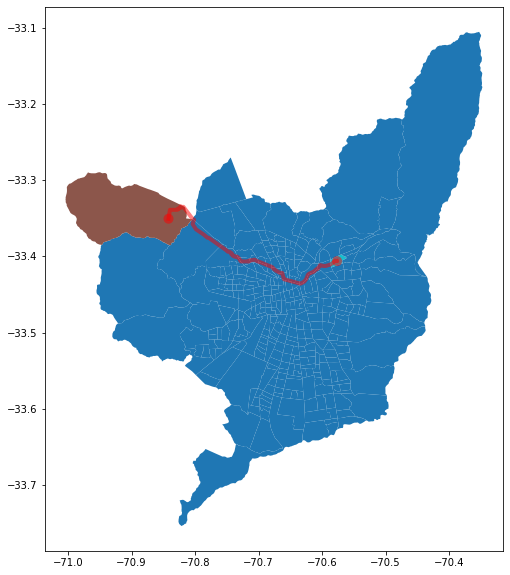

In [103]:
orig_node = ox.distance.nearest_nodes(red_pst, min_c['centroides'].xy[0][0], min_c['centroides'].xy[1][0])
dest_node = ox.distance.nearest_nodes(red_pst, max_c['centroides'].xy[0][0], max_c['centroides'].xy[1][0])

route_ps = nx.shortest_path(red_pst, orig_node, dest_node, weight = 'length')
cost_ps = nx.shortest_path_length(red_pst, orig_node, dest_node, weight = 'length')
fig, ax = ox.plot_graph_route(red_pst, route_ps, ax = dfFiltrado.plot(column = 'color_rgba', figsize = (10,10)), node_size = 0, figsize=(10,10))

# Mision 3

In [104]:
gdf_paradas["SEP"] = (gdf_paradas["E"]*1 + gdf_paradas["D"]*2 + gdf_paradas["C3"]*3 + gdf_paradas["C2"]*4 + gdf_paradas["ABC1"]*5)/gdf_paradas["ADIMARK_T"]
gdf_paradas["SEP_V"] = (1/5)*(((gdf_paradas["E"] - gdf_paradas["SEP"])**2 + (gdf_paradas["D"] - gdf_paradas["SEP"])**2 + (gdf_paradas["C3"] - gdf_paradas["SEP"])**2 + (gdf_paradas["C2"] - gdf_paradas["SEP"])**2 + (gdf_paradas["ABC1"] - gdf_paradas["SEP"])**2))
max_sep = gdf_paradas.loc[gdf_paradas['SEP'].idxmax()]
min_sep = gdf_paradas.loc[gdf_paradas['SEP'].idxmin()]
min_sep_v = gdf_paradas.loc[gdf_paradas['SEP_V'].idxmin()]

C:\Users\Juaco\AppData\Roaming\Python\Python39\site-packages\geopandas\geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


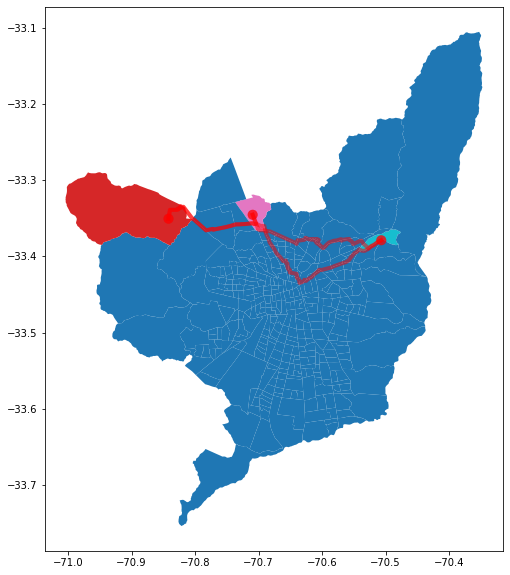

In [105]:
gdf_paradas['color_rgba'] = gdf_paradas.apply(
    lambda row: ('r' if row.equals(max_sep) else ('b' if row.equals(min_sep) else ('g' if row.equals(min_sep_v) else 'a'))) , axis=1)

node = ox.distance.nearest_nodes(red_pst, min_sep['centroides'].xy[0][0], min_sep['centroides'].xy[1][0])
node2 = ox.distance.nearest_nodes(red_pst, max_sep['centroides'].xy[0][0], max_sep['centroides'].xy[1][0])
node3 = ox.distance.nearest_nodes(red_pst, min_sep_v['centroides'].xy[0][0], min_sep_v['centroides'].xy[1][0])

route_ps = nx.shortest_path(red_pst, node, node2, weight = 'length')
route_ps2 = nx.shortest_path(red_pst, node2, node3, weight = 'length')
route_ps3 = nx.shortest_path(red_pst, node, node3, weight = 'length')
routes = [route_ps, route_ps2, route_ps3]
fig, ax = ox.plot_graph_routes(red_pst, routes, ax = gdf_paradas.plot(column = 'color_rgba', figsize = (10,10)), node_size = 0, figsize=(10,10))